<a href="https://colab.research.google.com/github/AshuMaths1729/COVID_jobs/blob/main/Our_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**COVID Jobs Paper**

By:
1. Ashutosh Agrahari
2. Ankur Veer
3. Pawan Singh
4. Anshuman Singh


1. Make two data - 1) 1991-2019 and 2) 1991- Jul 2020
2. Train model on two data. Let trained models be M1 and M2.
3. Make a dataframe with one column 'ds' with values from Jun 2019 to Jul 2020.
4. Generate predictions from the two trained models on this dataframe. Let them be P1 and P2.
5. The actual values for Jun 2019 to Jul 2020 are with us. Let it be C.
6. Combine the preds of two models as, 
    aP1 + bP2
7. Minimize the difference between actual and predicted values.
8. Minimize the expression, aP1 + bP2 - C, and find values of a and b using least squares approximation.
9. Use the calculated a and b to combine predictions on further timelines, from Aug 2020 onwards.


---



In [ ]:
import pandas as pd
import datetime
from fbprophet import Prophet
import os
# os.chdir('/content/drive/MyDrive/COVID_Jobs')

In [ ]:
# Make future dataframe
"""
fd = ['30-06-2019','31-07-2019','31-08-2019','30-09-2019','31-10-2019',\
  '30-11-2019','31-12-2019','31-01-2020','29-02-2020','31-03-2020','30-04-2020',\
    '31-05-2020','30-06-2020','31-07-2020','31-08-2020','30-09-2020','31-10-2020','30-11-2020']
"""


"\nfd = ['30-06-2019','31-07-2019','31-08-2019','30-09-2019','31-10-2019',  '30-11-2019','31-12-2019','31-01-2020','29-02-2020','31-03-2020','30-04-2020',    '31-05-2020','30-06-2020','31-07-2020','31-08-2020','30-09-2020','31-10-2020','30-11-2020']\n"

**Model 2** without COVID pattern

In [ ]:
### Model 2
new_df2 = pd.read_csv('Monthly_Unemployment_1991-2020.csv')
new_df2['ds'] = pd.to_datetime(new_df2['ds'], yearfirst=True)

# Train M2
m2 = Prophet(seasonality_mode='multiplicative', mcmc_samples=len(new_df2))
m2.fit(new_df2)

future = m2.make_future_dataframe(periods=0, freq='M')

# Preds 2
P2 = m2.predict(future)[['ds', 'yhat']]


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future

,ds
0,1991-12-31
1,1992-01-31
2,1992-02-29
3,1992-03-31
4,1992-04-30
...,...
339,2020-03-31
340,2020-04-30
341,2020-05-31
342,2020-06-30


**Model 1** with COVID pattern

In [ ]:
### Model 1
d1 = pd.read_excel('Unemployment_Rate_India_1991-2019.xlsx')
df1 = d1.rename(columns = {"Year": "ds", "Unemployment Rate":"y"})
df1['ds'] = pd.to_datetime(df1['ds'], yearfirst=True)

# interpolate data to get it for months
new_df1 = df1.set_index('ds').resample('M').interpolate(method='linear', axis=0, limit=None, inplace=False,\
         limit_direction='forward', limit_area=None, downcast=None).reset_index()

# Train M1
m1 = Prophet(seasonality_mode='multiplicative', mcmc_samples=len(d1))
m1.fit(new_df1)

# Preds 1
P1 = m1.predict(future)[['ds', 'yhat']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
p, q = new_df1.shape[0], new_df2.shape[0]
p_ratio = p/(p+q)
q_ratio = q/(p + q)
p_ratio, q_ratio

(0.4948604992657856, 0.5051395007342144)

In [ ]:
### Original Values (C)
C = new_df2['y']

In [ ]:
# Import modules
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

**Least Squares Approximation**

to estimate a and b, so as to combine results from models trained on both patterns.

In [ ]:
## Now implementing Least Squares Approximation
from scipy.optimize import leastsq

xdata = np.transpose(np.array([P1['yhat'],P2['yhat']]))
ydata = np.transpose(np.array(C))

In [ ]:
def func(params, xdata, ydata):
    return (ydata - np.dot(xdata, params))

In [ ]:
params = leastsq(func, [0,0], args=(xdata, ydata))
a, b = params[0]
a_, b_ = a*p_ratio, b*q_ratio
a_1, b_1 = a*q_ratio, b*p_ratio
params1, params2, params3 = (a, b) , (a_, b_), (a_1, b_1)
params1, params2, params3

((-0.009347898336120597, 1.0128869656589612),
 (-0.004625905637698446, 0.5116492161331611),
 (-0.004721992698422152, 0.5012377495258002))

In [ ]:
params1 = (-0.1113,1.1055)
params2 = (-0.0547, 0.5616)
params3 = (-0.0565, 0.5438)

so now **a = -13.344894120968593** and **b = 10.07420211311749**, as calculated using least squares approximation

Now we can use equation, aP1 + bP2 to combine predictions from both models.


---



---



In [ ]:
# Combined Predictions as per LSA and params1
res = np.dot(xdata, params1)
res_df = pd.DataFrame(res, columns=['yhat'])
LSA_preds1 = pd.concat([future, res_df], axis=1)
LSA_preds1

,ds,yhat
0,1991-12-31,5.076114
1,1992-01-31,5.454841
2,1992-02-29,5.062472
3,1992-03-31,4.993910
4,1992-04-30,6.615523
...,...,...
339,2020-03-31,7.852872
340,2020-04-30,10.339535
341,2020-05-31,10.558125
342,2020-06-30,8.105134


In [ ]:
# Combined Predictions as per LSA and params2
res = np.dot(xdata, params2)
res_df = pd.DataFrame(res, columns=['yhat'])
LSA_preds2 = pd.concat([future, res_df], axis=1)
LSA_preds2

,ds,yhat
0,1991-12-31,2.588806
1,1992-01-31,2.781233
2,1992-02-29,2.581879
3,1992-03-31,2.547068
4,1992-04-30,3.370892
...,...,...
339,2020-03-31,3.999082
340,2020-04-30,5.262343
341,2020-05-31,5.373395
342,2020-06-30,4.127213


In [ ]:
# Combined Predictions as per LSA and params2
res = np.dot(xdata, params3)
res_df = pd.DataFrame(res, columns=['yhat'])
LSA_preds3 = pd.concat([future, res_df], axis=1)
LSA_preds3

,ds,yhat
0,1991-12-31,2.487343
1,1992-01-31,2.673610
2,1992-02-29,2.480629
3,1992-03-31,2.446885
4,1992-04-30,3.244529
...,...,...
339,2020-03-31,3.853558
340,2020-04-30,5.076736
341,2020-05-31,5.184253
342,2020-06-30,3.977665


In [ ]:
dfC = pd.DataFrame(ydata, columns=['Actuals'])
comp_Res1 = pd.concat([LSA_preds1, dfC], axis=1)
comp_Res2 = pd.concat([LSA_preds2, dfC], axis=1)
comp_Res3 = pd.concat([LSA_preds3, dfC], axis=1)

Text(0.5, 1.0, 'Comparison of results of LSA predictions and params1')

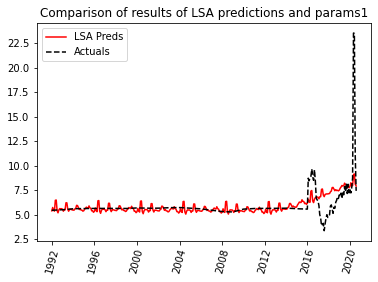

In [ ]:
plt.plot(comp_Res1['ds'], comp_Res1['yhat'], '-r')
plt.plot(comp_Res1['ds'], comp_Res1['Actuals'], '-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.legend(['LSA Preds', 'Actuals'])
plt.title('Comparison of results of LSA predictions and params1')

Text(0.5, 1.0, 'Comparison of results of LSA predictions and params2')

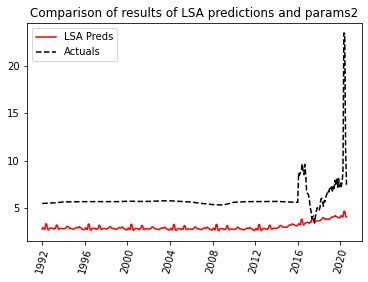

In [ ]:
plt.plot(comp_Res2['ds'], comp_Res2['yhat'], '-r')
plt.plot(comp_Res2['ds'], comp_Res2['Actuals'], '-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.legend(['LSA Preds', 'Actuals'])
plt.title('Comparison of results of LSA predictions and params2')

Text(0.5, 1.0, 'Comparison of results of LSA predictions and params3')

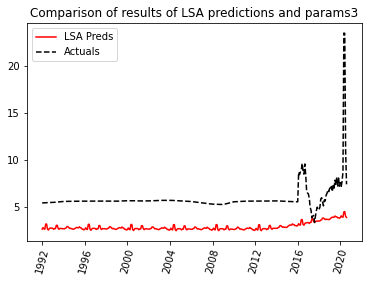

In [ ]:
plt.plot(comp_Res3['ds'], comp_Res3['yhat'], '-r')
plt.plot(comp_Res3['ds'], comp_Res3['Actuals'], '-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.legend(['LSA Preds', 'Actuals'])
plt.title('Comparison of results of LSA predictions and params3')

**Predicting on future timelines**


---



In [ ]:
len(dfC)

344

In [ ]:
n_mths = 17
future_timeline = m2.make_future_dataframe(periods=n_mths, freq='M', include_history=False)

In [ ]:
future_timeline

,ds
0,2020-08-31
1,2020-09-30
2,2020-10-31
3,2020-11-30
4,2020-12-31
5,2021-01-31
6,2021-02-28
7,2021-03-31
8,2021-04-30
9,2021-05-31


           ds       yhat
0  2020-08-31   8.417445
1  2020-09-30   8.734133
2  2020-10-31   8.841325
3  2020-11-30   8.848144
4  2020-12-31   8.894914
5  2021-01-31   8.470014
6  2021-02-28   8.724796
7  2021-03-31   8.719021
8  2021-04-30  10.337501
9  2021-05-31  10.415379
10 2021-06-30   9.013054
11 2021-07-31   8.578332
12 2021-08-31   9.047608
13 2021-09-30   9.123270
14 2021-10-31   9.194500
15 2021-11-30   9.111131
16 2021-12-31   9.190456


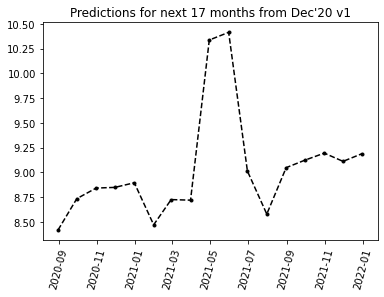

In [ ]:
# Make future dataframe
# n_mths = 17
# future_timeline = m2.make_future_dataframe(periods=n_mths, freq='M', include_history=False)

p1 = m1.predict(future_timeline)[['ds', 'yhat']]
p2 = m2.predict(future_timeline)[['ds', 'yhat']]

x = np.transpose(np.array([p1['yhat'],p2['yhat']]))
res = np.dot(x, params1)
final_preds1 = pd.DataFrame(res, columns=['yhat'])
final_preds1 = pd.concat([future_timeline, final_preds1], axis=1)
print(final_preds1)

plt.plot(final_preds1['ds'], final_preds1['yhat'], '.-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.title('Predictions for next %d months from Dec\'20 v1'%(n_mths))
plt.savefig("v1.pdf")

            ds      yhat
0   1991-12-31  2.637522
1   1992-01-31  2.869319
2   1992-02-29  2.669679
3   1992-03-31  2.628459
4   1992-04-30  3.257701
..         ...       ...
356 2021-08-31  4.429983
357 2021-09-30  4.444713
358 2021-10-31  4.466316
359 2021-11-30  4.470333
360 2021-12-31  4.467717

[361 rows x 2 columns]


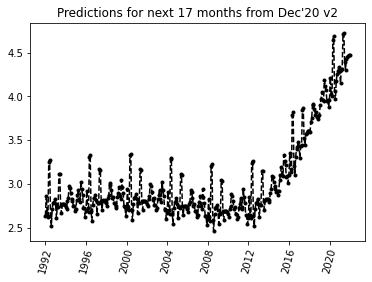

In [ ]:
# Make future dataframe
# n_mths = 17
# future_timeline = m2.make_future_dataframe(periods=n_mths, freq='M', include_history=False)

p1 = m1.predict(future_timeline)[['ds', 'yhat']]
p2 = m2.predict(future_timeline)[['ds', 'yhat']]

x = np.transpose(np.array([p1['yhat'],p2['yhat']]))
res = np.dot(x, params2)
final_preds2 = pd.DataFrame(res, columns=['yhat'])
final_preds2 = pd.concat([future_timeline, final_preds2], axis=1)
print(final_preds2)

plt.plot(final_preds2['ds'], final_preds2['yhat'], '.-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.title('Predictions for next %d months from Dec\'20 v2'%(n_mths))
plt.savefig("v2.pdf")

            ds      yhat
0   1991-12-31  2.574946
1   1992-01-31  2.802040
2   1992-02-29  2.606436
3   1992-03-31  2.565993
4   1992-04-30  3.182427
..         ...       ...
356 2021-08-31  4.331284
357 2021-09-30  4.345704
358 2021-10-31  4.366846
359 2021-11-30  4.370803
360 2021-12-31  4.368249

[361 rows x 2 columns]


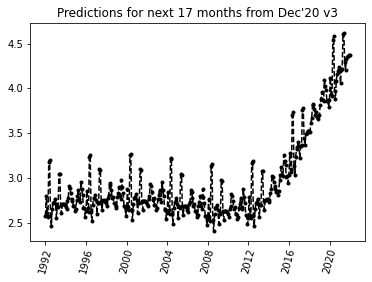

In [ ]:
# Make future dataframe
# n_mths = 17
# future_timeline = m2.make_future_dataframe(periods=n_mths, freq='M', include_history=False)

p1 = m1.predict(future_timeline)[['ds', 'yhat']]
p2 = m2.predict(future_timeline)[['ds', 'yhat']]

x = np.transpose(np.array([p1['yhat'],p2['yhat']]))
res = np.dot(x, params3)
final_preds3 = pd.DataFrame(res, columns=['yhat'])
final_preds3 = pd.concat([future_timeline, final_preds3], axis=1)
print(final_preds3)

plt.plot(final_preds3['ds'], final_preds3['yhat'], '.-k', linestyle='dashed')
plt.xticks(rotation=75)
plt.title('Predictions for next %d months from Dec\'20 v3'%(n_mths))
plt.savefig("v3.pdf")

In [ ]:
final_preds1.to_csv('Preds_1.csv')
final_preds2.to_csv('Preds_2.csv')
final_preds3.to_csv('Preds_3.csv')